<a href="https://colab.research.google.com/github/mralamdari/indoor-localization/blob/master/indoor_localization_Colab_Full_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Project Link](https://github.com/nikola310/indoor-localization)

In [ ]:
!git clone https://github.com/nikola310/indoor-localization.git

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d mehdimka/ble-rssi-dataset
!unzip \*.zip && rm *.zip

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from os.path import exists
from os import mkdir

min_max_ibeacons = False # change to True to see min/max values of the ibeacons
print_location = False # change to True to see location values
print_ibeacon_histograms = False # change to True to see ibeacon histograms
save_class_histograms = False
save_plots = True
plots_directory = './plots/'

def get_plots(dataframe):
    if not exists(plots_directory):
        mkdir(plots_directory)
    dataframe.drop(['x', 'y'], axis=1, inplace=True)
    column_names = dataframe.columns

    for index, element in enumerate(dataframe.columns):
        for _, next_element in enumerate(column_names[index+1:]):
            plt.scatter(dataframe[element].values, dataframe[next_element])
            filename = "_".join([element, next_element])

            plt.savefig("".join([plots_directory, filename]))
            plt.clf()
            plt.close()

def ascii_to_coord(loc):
    '''
        Convert ASCII location to numerical coordinate

        Parameters:
            - loc = location as a letter

        Returns:
            - numerical coordinate scaled to A - W
    '''
    return ord(loc.upper()) - 64

def extract_new_features_and_save_them(dataframe, file_name):
    dataframe = dataframe.abs()

    if 'x' in dataframe.columns:
        column_names = list(dataframe.columns.values[:-2])
    else:
        column_names = list(dataframe.columns.values)

    for index, element in enumerate(column_names):
        for _, next_elem in enumerate(column_names[index+1:]):
            dataframe["_".join([element, next_elem])] = dataframe[element] - dataframe[next_elem]

    dataframe.drop(column_names, axis=1, inplace=True)

    if 'x' in dataframe.columns:
        x_y = dataframe[['x', 'y']]

        dataframe.drop(['x', 'y'], axis=1, inplace=True)
        dataframe['x'] = x_y['x']
        dataframe['y'] = x_y['y']

    dataframe.to_csv(file_name, sep=',', index=False)

def convert_location_to_x_y(dataframe):
    df['x'] = df['location'].str[0]
    df['y'] = df['location'].str[1:]

    df['x'] = df['x'].apply(ascii_to_coord)
    df['y'] = df['y'].astype(int)

    df.drop(['location'], axis=1, inplace=True)

if __name__ == "__main__":

    df = pd.read_csv('iBeacon_RSSI_Labeled.csv')
    dfU = pd.read_csv('iBeacon_RSSI_Unlabeled.csv')

    # Location for unlabeled dataset is always the same, i.e. ?
    # Date information is useless in this case.
    dfU.drop(['location', 'date'], axis=1, inplace=True)
    df.drop(['date'], axis=1, inplace=True)

    if min_max_ibeacons:
        print('Minimum values in each column of labeled data: ')
        print(df.min())
        print('Maximum values in each column of labeled data: ')
        print(df.max())

        print('Minimum values in each column of unlabeled data: ')
        print(dfU.min())
        print('Maximum values in each column of unlabeled data: ')
        print(dfU.max())
        # Values of ibeacons is always between -200 and -50

    if print_location:
        print(df.location)

        print(df.location.max())
        # Unlike in the image, values along the x axis go from A to W.

    if save_class_histograms:
        sns.countplot(x="location", data=df)
        location_occurences = df['location'].value_counts()
        pd.set_option('display.max_rows', len(location_occurences))
        location_dictionary = location_occurences.to_dict()
        print(location_occurences)
        print(sorted(location_dictionary))

    convert_location_to_x_y(df)

    if print_ibeacon_histograms:
        for col in df.columns[0:10]:
            df.hist(column = col)
            plt.show()

    if save_plots:
        get_plots(df.copy(deep=True))


    # Normalize data
    float_labeled_data = df.iloc[:, :-2].values.astype(float)

    min_max_scaler = MinMaxScaler()
    scaled_labeled_data = min_max_scaler.fit_transform(float_labeled_data)

    labeled_data_copy = df.copy(deep=True)

    for i in range(13):
        labeled_data_copy.iloc[:, i] = scaled_labeled_data[:, i]

    float_unlabeled_data = dfU.values.astype(float)
    scaled_unlabeled_data = min_max_scaler.fit_transform(float_unlabeled_data)

    unlabeled_data_copy = dfU.copy(deep=True)

    for i in range(13):
        unlabeled_data_copy.iloc[:, i] = scaled_unlabeled_data[:, i]

    # Save processed data
    df.to_csv('data_labeled.csv', sep=',', index=False)
    extract_new_features_and_save_them(df.copy(deep=True), 'extracted_features.csv')
    labeled_data_copy.to_csv('labeled_data_scaled.csv', sep=',', index=False)
    extract_new_features_and_save_them(labeled_data_copy.copy(deep=True), 'extracted_features_scaled.csv')
    dfU.to_csv('data_unlabeled.csv', sep=',', index=False)
    extract_new_features_and_save_them(dfU.copy(deep=True), 'extracted_features_unlabeled.csv')
    unlabeled_data_copy.to_csv('unlabeled_data_scaled.csv', sep=',', index=False)
    extract_new_features_and_save_them(unlabeled_data_copy.copy(deep=True), 'extracted_features_scaled_unlabeled.csv')

9/9 [==============================] - 0s 2ms/step
Mean distance: 2.007369521069339


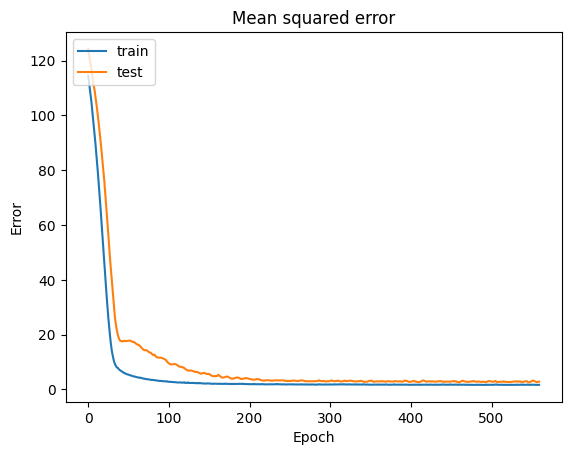

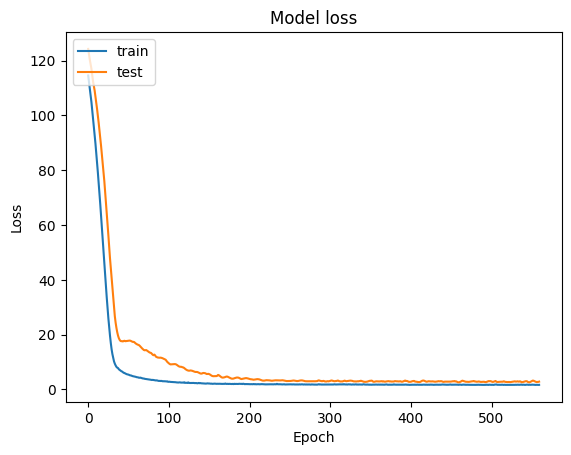

9/9 [==============================] - 0s 2ms/step
Mean distance: 5.018051647718132


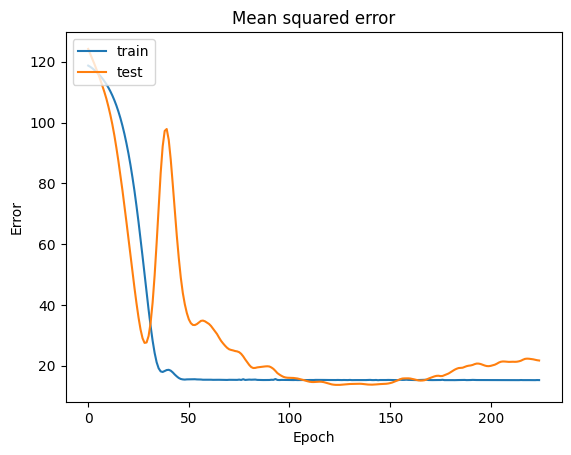

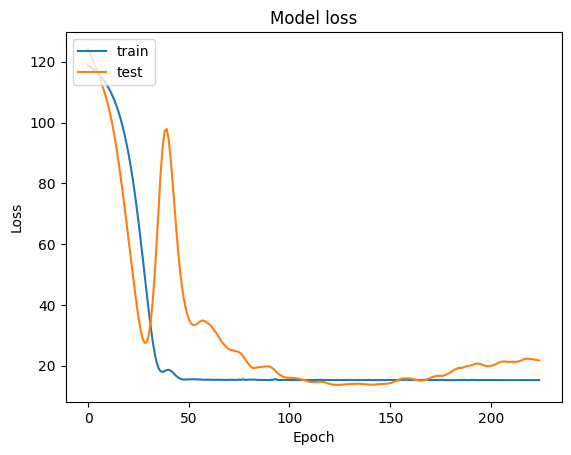

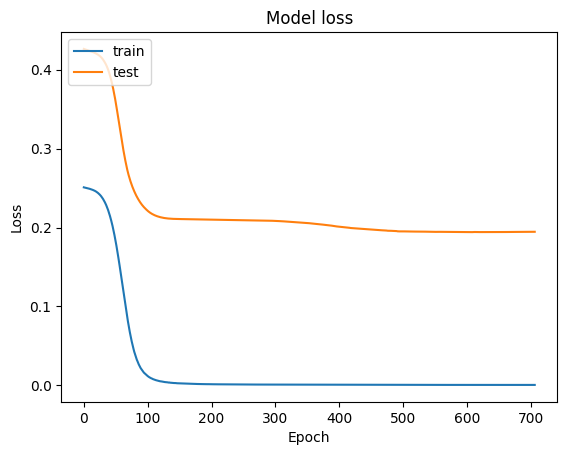

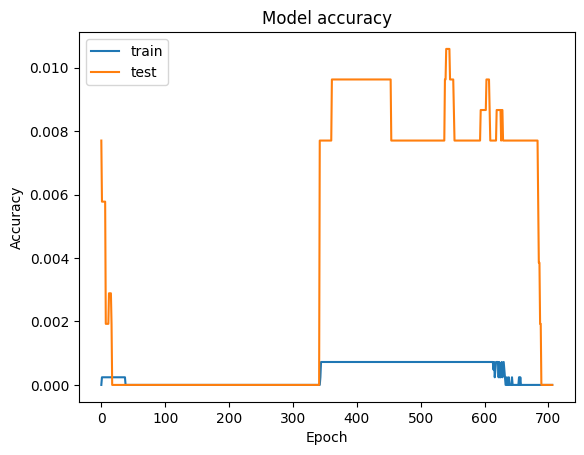

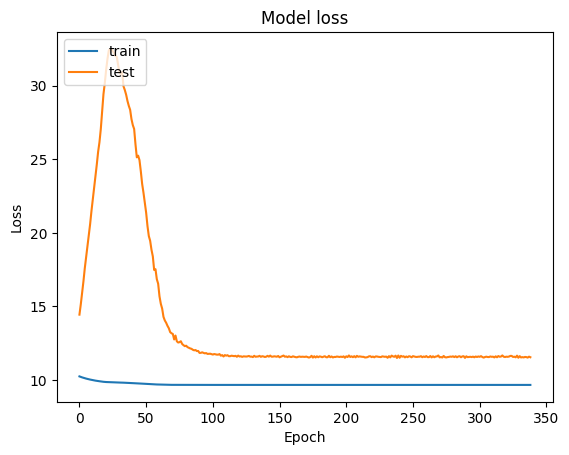

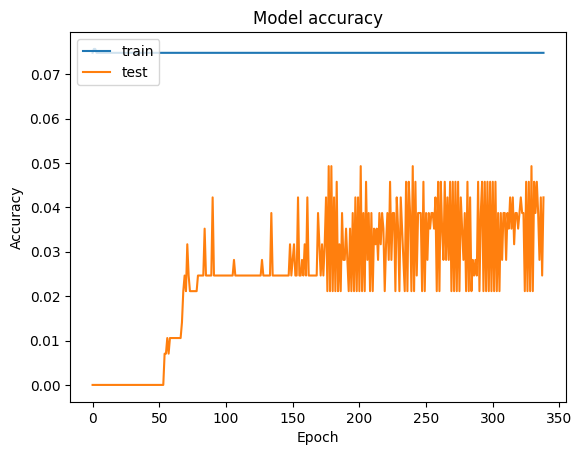

9/9 [==============================] - 0s 2ms/step


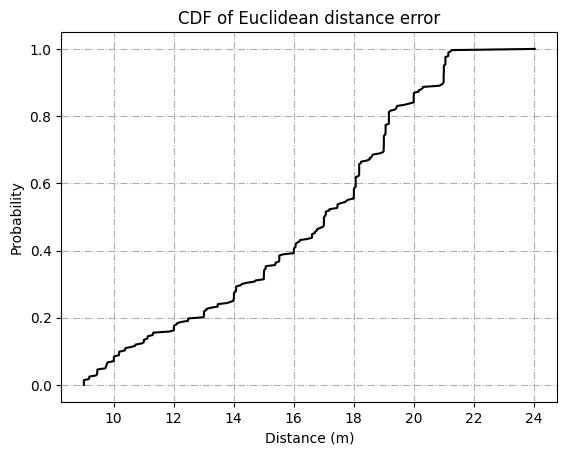

Mean distance: 16.265208901786625


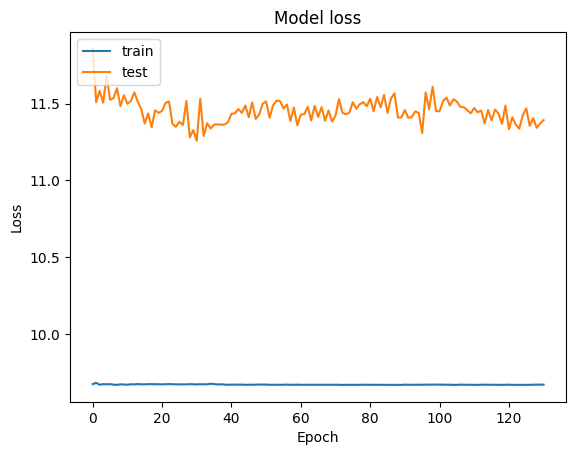

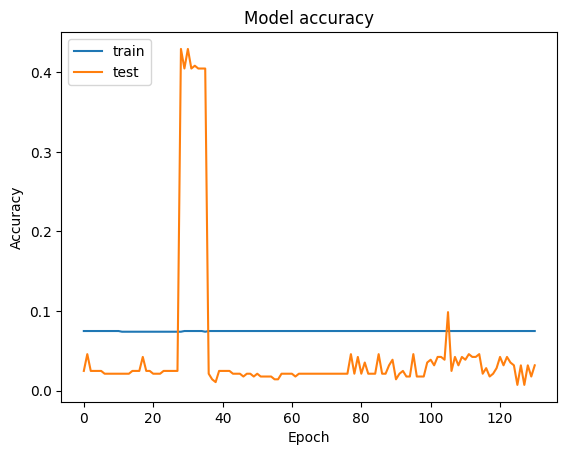

9/9 [==============================] - 0s 2ms/step


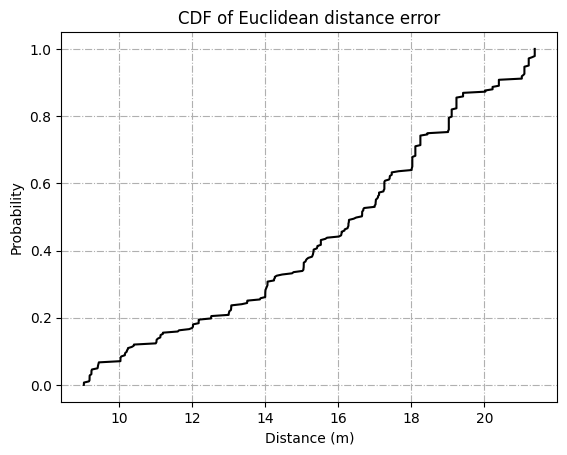

Mean distance: 15.920664186265608


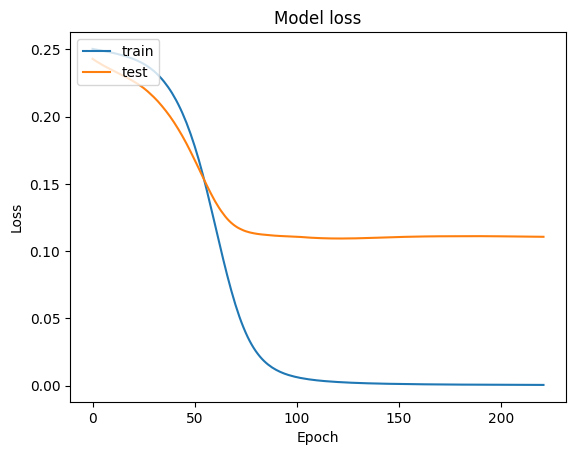

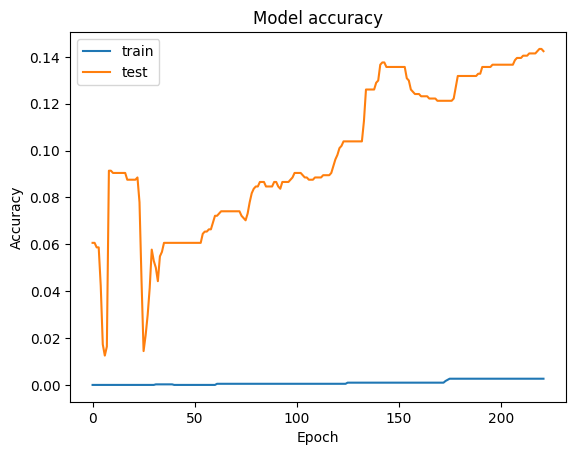

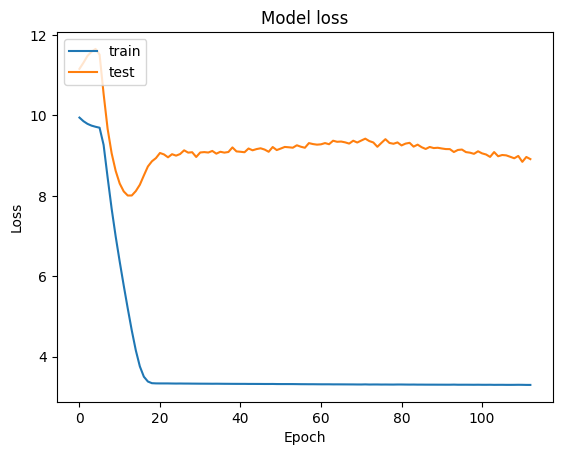

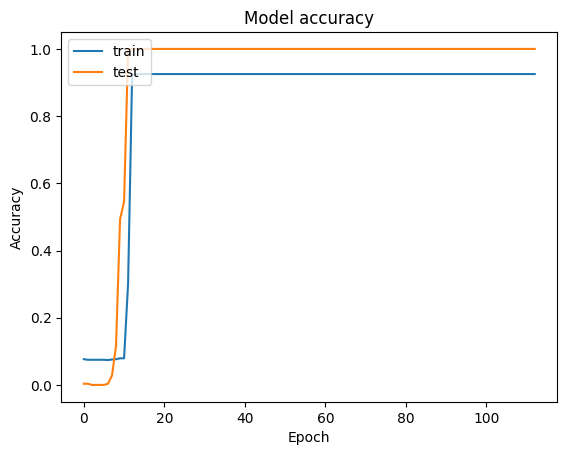

9/9 [==============================] - 0s 2ms/step


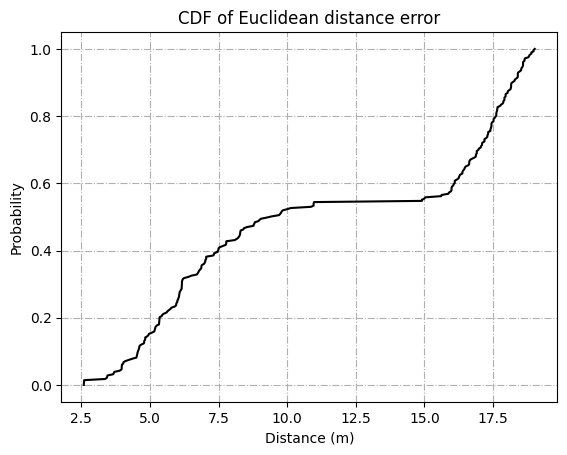

Mean distance: 11.325335611644606


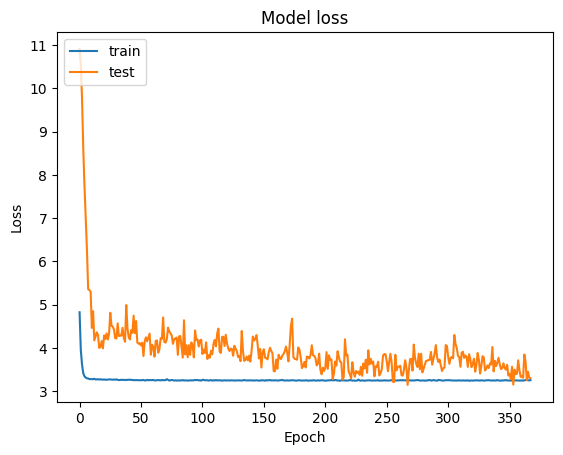

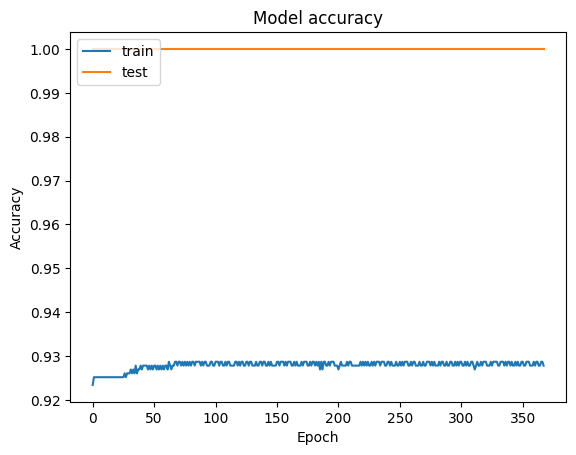

9/9 [==============================] - 0s 2ms/step


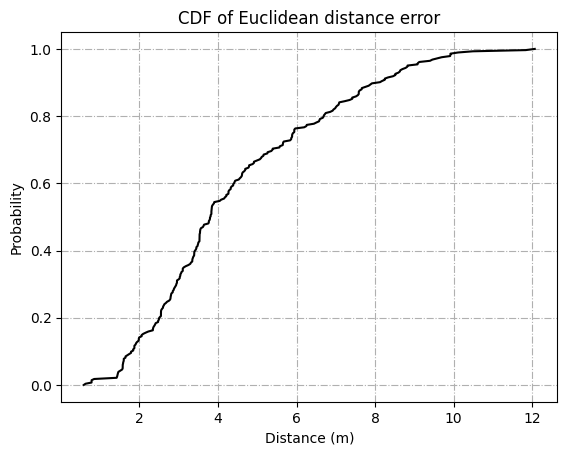

Mean distance: 4.453129917410443


In [50]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from pandas import read_csv
from pandas import DataFrame
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - tf.cast(y_true, tf.float32)), axis=-1))

def get_euclidean_distances_and_mean(points1, points2):
    x1, y1 = points1
    x2, y2 = points2
    x1, y1 = np.array(x1), np.array(y1)
    x2, y2 = np.array(x2), np.array(y2)
    distance_x = x1 - x2
    distance_y = y1 - y2
    squared_distance_x = distance_x ** 2
    squared_distance_y = distance_y ** 2
    distances = squared_distance_x + squared_distance_y
    euclidean_distances = np.sqrt(distances)
    return euclidean_distances, np.mean(euclidean_distances)

def create_neural_network(input_dimension):
    model = Sequential()
    model.add(Dense(50, input_dim=input_dimension, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, activation='relu'))

    model.compile(loss='mse', optimizer=Adam(.001), metrics=['mse'])
    return model

def prepare_data_for_training(path_to_file, csv_file=True):
    if csv_file:
      data = read_csv(path_to_file, index_col=None)
    else:
      data = path_to_file
    y = data.iloc[:, -2:]
    x = data.iloc[:, :-2]

    return train_test_split(x, y, test_size = .2, shuffle = False)

def train_neural_network(neural_network, train_data, validation_data, number_of_epochs, batch_size):
    es = EarlyStopping(monitor = 'val_loss', patience = 100, verbose = 0, mode = 'auto', restore_best_weights = True)
    return neural_network.fit(x = train_data[0].astype(int), y = train_data[1].astype(int), validation_data = validation_data, epochs=number_of_epochs, batch_size=batch_size,  verbose=0, callbacks = [es])

def plot_history(history):
    if 'mse' in history.history.keys():
        plt.plot(history.history['mse'])
        plt.plot(history.history['val_mse'])
        plt.title('Mean squared error')
        plt.ylabel('Error')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    if 'loss' in history.history.keys():
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    if 'accuracy' in history.history.keys():
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

def plot_cumulative_density_function(distances, save_file_name):
    sorted_distances = np.sort(distances)
    prob_deep = 1. * np.arange(len(sorted_distances))/(len(sorted_distances) - 1)

    _, axes = plt.subplots()
    axes.plot(sorted_distances, prob_deep, color='black')
    plt.title('CDF of Euclidean distance error')
    plt.xlabel('Distance (m)')
    plt.ylabel('Probability')
    plt.grid(True)
    gridlines = axes.get_xgridlines() + axes.get_ygridlines()

    for line in gridlines:
        line.set_linestyle('-.')

    # 'Figure_CDF_error.png'
    plt.savefig(save_file_name, dpi=300)
    plt.show()
    plt.close()

def run_script_on_data(filename, plot=True, csv_file=True):
    train_x, validation_x, train_y, validation_y = prepare_data_for_training(filename, csv_file)

    neural_network = create_neural_network(train_x.shape[1])

    history = train_neural_network(neural_network, (train_x, train_y), (validation_x, validation_y), 1000, 1000)

    predictions = neural_network.predict(validation_x)
    _, mean_distance = get_euclidean_distances_and_mean((predictions[:, 0], predictions[:, 1]),
                                                    (validation_y["x"], validation_y["y"]))

    if plot:
      print('Mean distance: ' + str(mean_distance))
      plot_history(history)
    return mean_distance

def create_autoencoder(input_dimension):
    model = Sequential()
    model.add(Dense(50, input_dim=input_dimension, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(25, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(input_dimension, activation='sigmoid')) #13

    model.compile(optimizer=Adam(.0001, clipnorm = .5, clipvalue = .5),
              loss='mse', metrics=['accuracy'])
    return model

def build_autoencoder_neural_network(autoencoder):
    predictions = Dense(2, activation = 'relu')(autoencoder.layers[3].output)
    neural_network = Model(inputs=autoencoder.input, outputs=predictions)
    return neural_network

def set_trainable_layers(model):
    for layer in model.layers[:-2]:
        layer.trainable = False

def set_new_trainable_layers(model):
    for layer in model.layers[:-2]:
        layer.trainable = True


def run_autoencoder_scenario_on_data(path_to_unlabeled_data, path_to_labeled_data):
    unlabeled_data = read_csv(path_to_unlabeled_data, index_col=None)

    train_unlabeled, validation_unlabeled = train_test_split(unlabeled_data, test_size = .2, shuffle = False)

    autoencoder = create_autoencoder(train_unlabeled.shape[1])
    history = train_neural_network(autoencoder, (train_unlabeled, train_unlabeled), (validation_unlabeled, validation_unlabeled), 1000, 1000)
    plot_history(history)

    neural_network = build_autoencoder_neural_network(autoencoder)
    set_trainable_layers(neural_network)
    neural_network.compile(optimizer=Adam(.001, clipnorm = .5, clipvalue = .5),
              loss=rmse, metrics=['accuracy'])

    train_x, validation_x, train_y, validation_y = prepare_data_for_training(path_to_labeled_data)

    history = train_neural_network(neural_network, (train_x, train_y), (validation_x, validation_y), 1000, 50)

    plot_history(history)
    predictions = neural_network.predict(validation_x)
    distances, mean_distance = get_euclidean_distances_and_mean((predictions[:, 0], predictions[:, 1]),
                                                    (validation_y["x"], validation_y["y"]))

    plot_cumulative_density_function(distances, 'CDF_train_new_decoder.png')
    print('Mean distance: ' + str(mean_distance))

    set_new_trainable_layers(neural_network)
    neural_network.compile(optimizer=Adam(.001, clipnorm = .5, clipvalue = .5),
              loss=rmse, metrics=['accuracy'])

    train_x, validation_x, train_y, validation_y = prepare_data_for_training(path_to_labeled_data)

    history = train_neural_network(neural_network, (train_x, train_y), (validation_x, validation_y), 1000, 50)

    plot_history(history)

    predictions = neural_network.predict(validation_x)
    distances, mean_distance = get_euclidean_distances_and_mean((predictions[:, 0], predictions[:, 1]),
                                                    (validation_y["x"], validation_y["y"]))

    plot_cumulative_density_function(distances, 'CDF_train_full_neural_network.png')
    print('Mean distance: ' + str(mean_distance))


if __name__ == "__main__":
    run_script_on_data('data_labeled.csv')
    run_script_on_data('labeled_data_scaled.csv')

    run_autoencoder_scenario_on_data('extracted_features_scaled_unlabeled.csv', 'extracted_features_scaled.csv')
    run_autoencoder_scenario_on_data('unlabeled_data_scaled.csv', 'labeled_data_scaled.csv')

#GA with indoor localization

7/7 [==============================] - 0s 2ms/step
Mean distance: 9.756020569006642


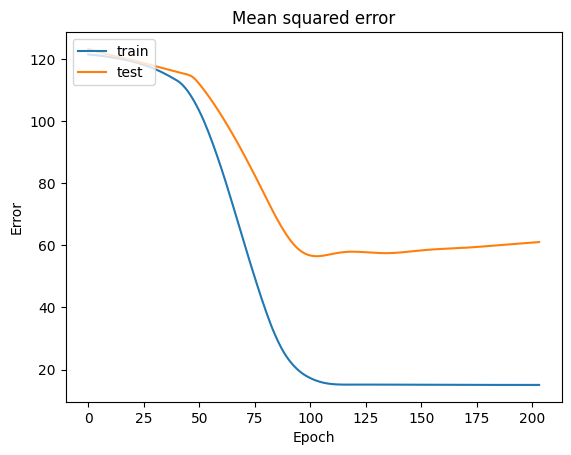

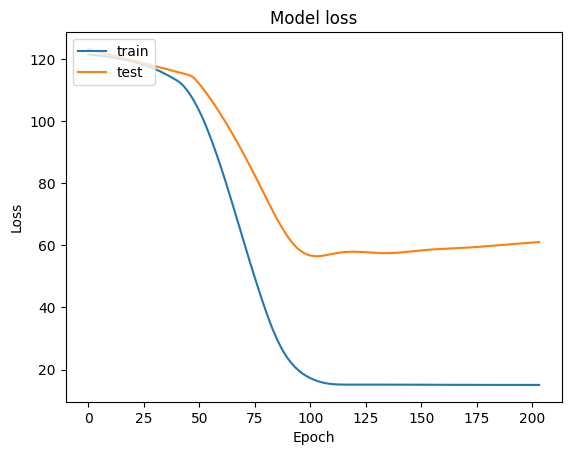

9.756020569006642
7/7 [==============================] - 0s 4ms/step
Mean distance: 5.997902063770919


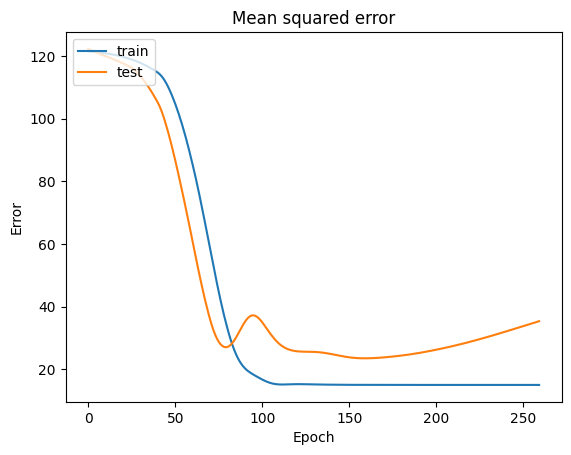

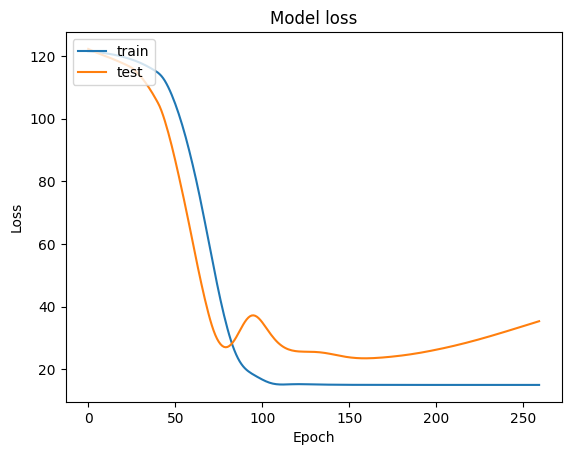

5.997902063770919
7/7 [==============================] - 0s 2ms/step
Mean distance: 5.98080426975612


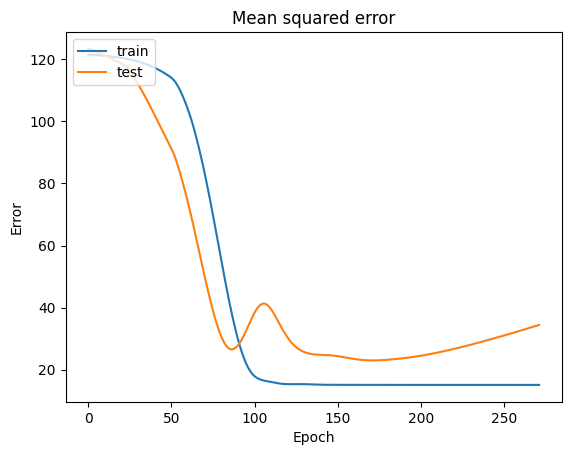

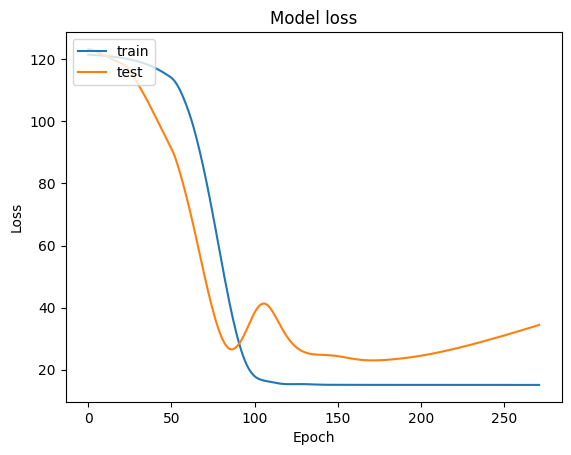

5.98080426975612
7/7 [==============================] - 0s 2ms/step
Mean distance: 5.787669138116529


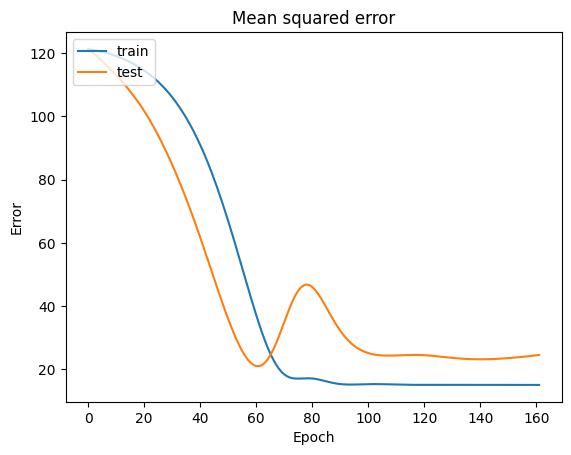

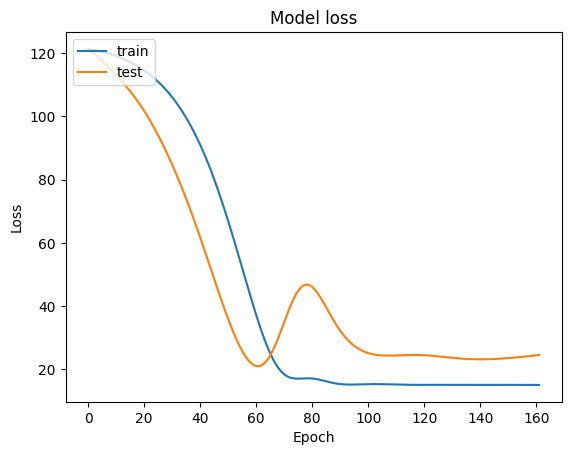

5.787669138116529
7/7 [==============================] - 0s 2ms/step
Mean distance: 6.011219909689564


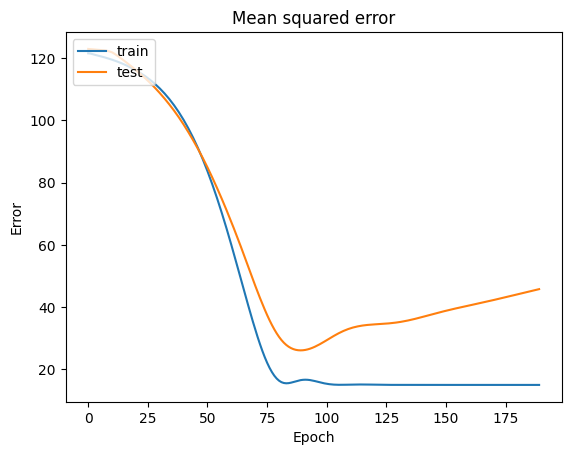

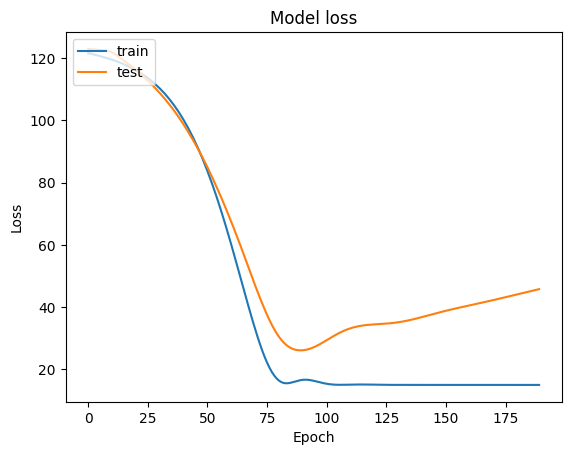

6.011219909689564
7/7 [==============================] - 0s 3ms/step
Mean distance: 5.005750951868416


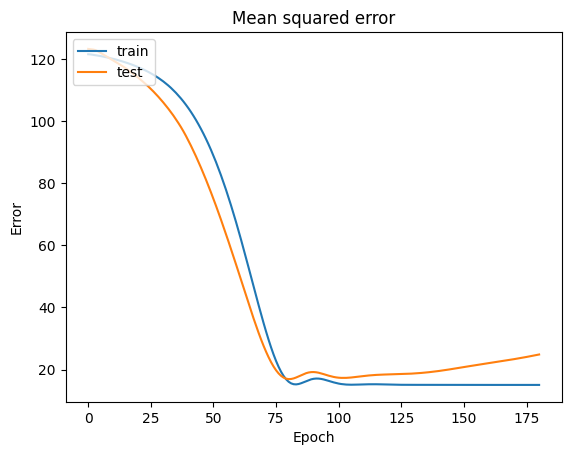

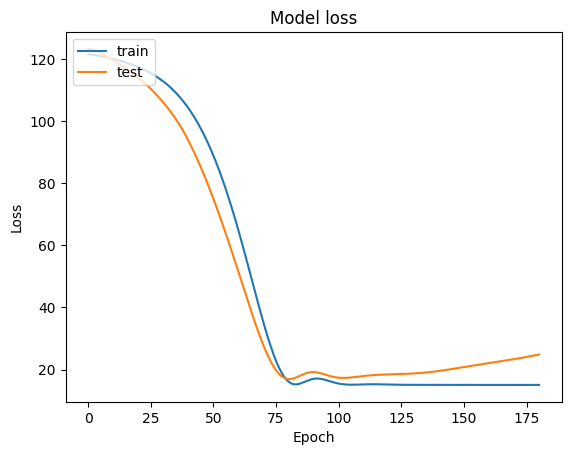

5.005750951868416
7/7 [==============================] - 0s 2ms/step
Mean distance: 6.691918101936924


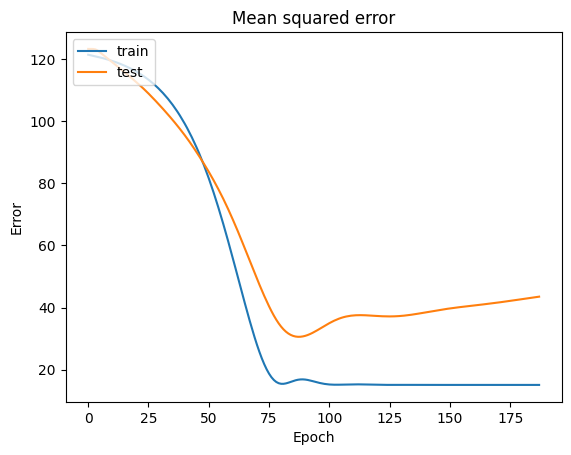

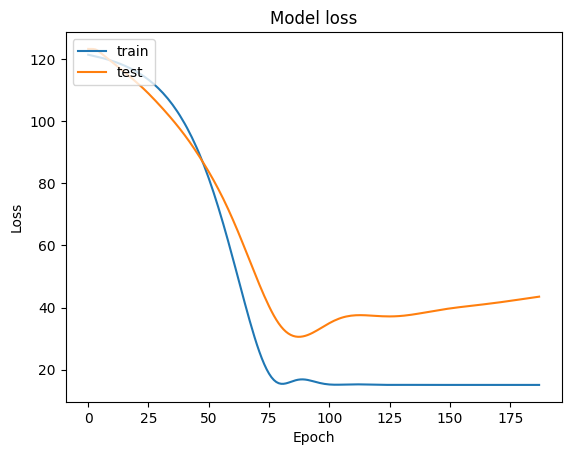

6.691918101936924
7/7 [==============================] - 0s 2ms/step
Mean distance: 14.097314553927818


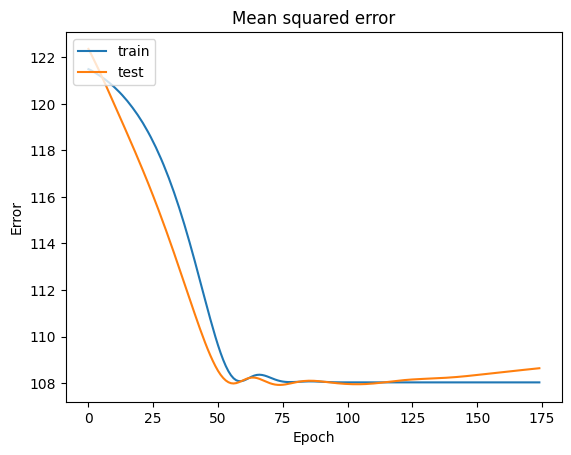

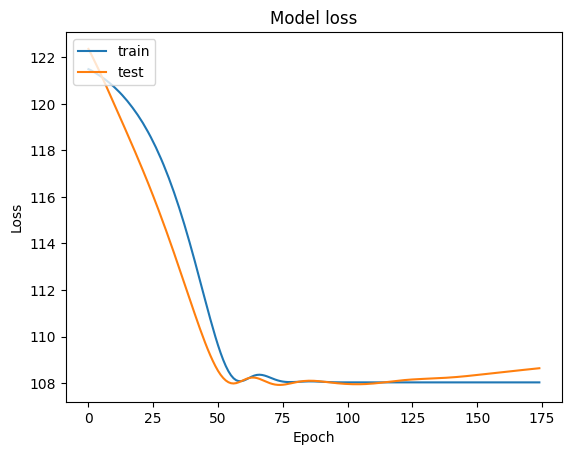

14.097314553927818
7/7 [==============================] - 0s 2ms/step
Mean distance: 5.847570724048818


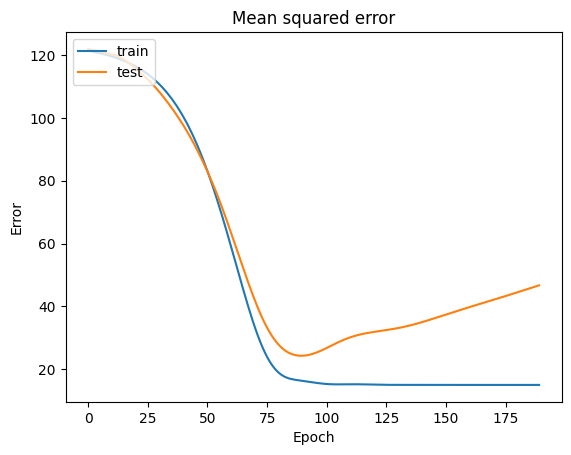

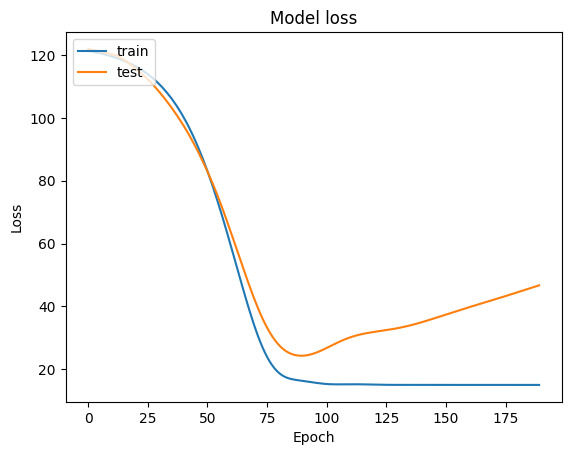

5.847570724048818
7/7 [==============================] - 0s 2ms/step
Mean distance: 5.5786324253986415


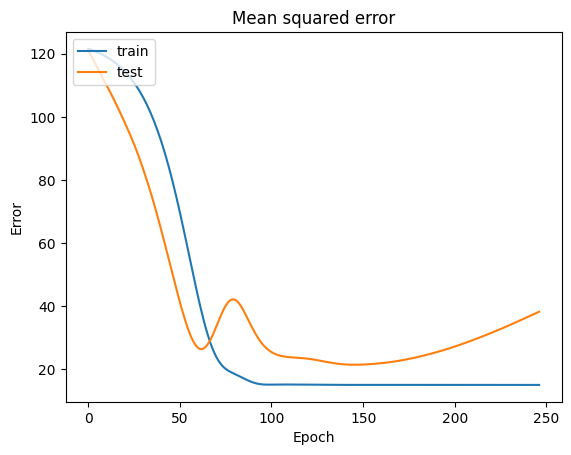

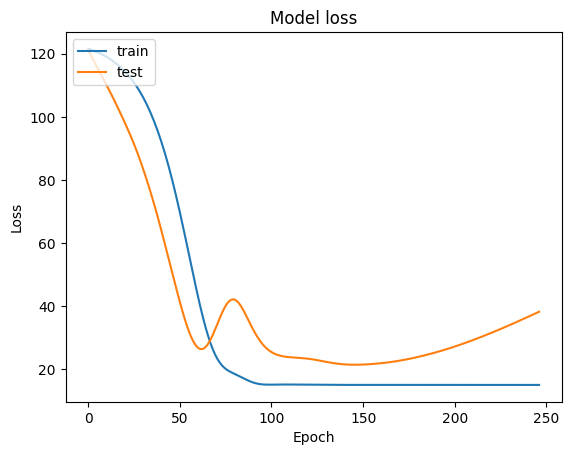

5.5786324253986415


In [51]:
data = pd.read_csv('/content/labeled_data_scaled.csv')

pop_size=1000
for i in range(10):
  df = data.sample(frac=1, random_state=32, ignore_index=True).iloc[0: pop_size, :]
  df.sample(frac=1, random_state=32, axis=1)
  result = run_script_on_data(df, plot=True, csv_file=False)
  print(result)